In [1]:
# math 
import numpy as np

# random
from numpy.random import rand, randn
np.random.seed(6)

# dataframes
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# linear regression two ways
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# pytorch utils
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(324891)

from patsy import dmatrices

In [2]:
# plot line y = w*x+b
def plotline(w,b, xmin=-100,xmax=100,nsamples=100,label=''):
    x = np.linspace(xmin, xmax, nsamples)
    y = w * x + b
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

In [3]:
# plot function y = f(x)
def plotfunc(f, xmin=-100,xmax=100,nsamples=100,label=""):
    x = np.linspace(xmin, xmax, nsamples)
    y = f(x)
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

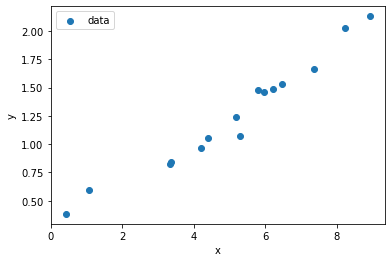

In [4]:
# Generate and plot data
n = 15
def sample_data(num_points):
    x = rand(num_points)*10
    y = .2 + .2*x + .1*np.sin(x) + .1*randn(num_points) - .01*((x-5)/6)**4
    return x,y

x,y = sample_data(n)


def plotdata(x=x,y=y, margin=.05):
    plt.scatter(x,y, label="data")
    plt.legend(loc="upper left")
    plt.xlabel("x") 
    plt.ylabel("y")     
    range_y = np.max(y) - np.min(y)
    range_x = np.max(x) - np.min(x)
    plt.ylim([np.min(y)-margin*range_y,np.max(y)+margin*range_y])
    plt.xlim([np.min(x)-margin*range_x,np.max(x)+margin*range_x])
    
plotdata()
plt.show()

# Approximating with the mean

In [5]:
# the mean solves a very simple least squares problem:
X = np.ones((n,1))
w = np.linalg.lstsq(X, y)[0]

<ipython-input-5-6dd8b0414b56>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


In [6]:
# check the solution to our least squares problem is the mean
np.abs(np.mean(y) - w[0])

2.220446049250313e-16

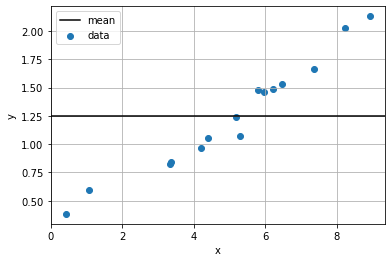

In [7]:
# plot the fit
plotdata()
plotline(0, w[0], label="mean")
plt.show()

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

# Approximating with a line

In [8]:
X = np.column_stack([x, np.ones(n)])
print(X)

[[8.92860151 1.        ]
 [3.31979805 1.        ]
 [8.21229123 1.        ]
 [0.41696626 1.        ]
 [1.0765668  1.        ]
 [5.95052064 1.        ]
 [5.29817362 1.        ]
 [4.18807429 1.        ]
 [3.35407849 1.        ]
 [6.22519432 1.        ]
 [4.38141426 1.        ]
 [7.35882106 1.        ]
 [5.18036412 1.        ]
 [5.788586   1.        ]
 [6.45355096 1.        ]]


# How to fit a least squares model
There are many ways to fit a least squares model in python!
1. QR decomposition + `scipy.linalg.solve`
2. `numpy.linalg.lstsq`
3. `statsmodels.OLS`
4. `sklearn.LinearRegression()`

In [9]:
# method 0: scipy
from scipy.linalg import qr, solve
Q,R = qr(X, mode='economic')
w = solve(R, Q.T @ y)
w

array([0.20462642, 0.21131099])

In [10]:
# method 1: numpy
w = np.linalg.lstsq(X, y)[0]
w

<ipython-input-10-4844ed0cbb71>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


array([0.20462642, 0.21131099])

In [11]:
# method 2: statsmodels
model = sm.OLS(y, X).fit()
w = model.params
w

array([0.20462642, 0.21131099])

In [12]:
# method 3: sklearn
model = LinearRegression().fit(x[None,].T,y)
w = np.array([model.coef_[0], model.intercept_])
w

array([0.20462642, 0.21131099])

Below we have to do some work to reconcile the default types of NumPy and PyTorch. Note that NumPy will default to float64 on a 64-bit system. PyTorch models default to float32 as GPUs can do up to 64x the operations per clock cycle when using float32 instead of float64. 

[CUDA operations per cycle comparison](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#arithmetic-instructions)

In [13]:
# method 4: PyTorch via SGD

def TorchLinRegModel(n : int = 2):
    """Create a simple linear regression model in PyTorch. Note that
    we're manually including the bias in this demo."""
    return nn.Linear(in_features=n, out_features=1, bias=False)

model = TorchLinRegModel()
model.zero_grad()
optimizer = optim.SGD(model.parameters(), lr=5e-6)
loss_function = nn.MSELoss()

n_epochs = 5000
batch_size = 8

for epoch in range(n_epochs):
    # Let's do a random order after converting to a torch array
    shuffled_indices = torch.randperm(x.shape[0])
    for batch in range(0, x.shape[0], batch_size):
        sample_idxs = shuffled_indices[batch:batch+batch_size]
        
        # Read minibatch data. PyTorch models default to float32  
        # so we need to convert from double precision to float32
        tensor = torch.from_numpy(X[sample_idxs, :]).float()
        output = model(tensor)
        
        batch_labels = torch.from_numpy(y[sample_idxs]).float()
        batch_labels = batch_labels.view(-1, 1)
        
        # loss.backward() calculates the gradient of the loss with
        # respect to the weights
        loss = loss_function(output, batch_labels)
        loss.backward()
        
        # optimizer.step() moves in the direction of the gradient
        # based on the learning rate (i.e. step size)
        optimizer.step()
        
        # PyTorch is still saving our past gradient even though we 
        # changed our model parameters. Clearing them here prevents
        # us from accidentally applying them again.
        optimizer.zero_grad()
        
        
wpytorch = list(model.parameters())[0][0].detach().numpy()
wpytorch

array([0.17200051, 0.23789968], dtype=float32)

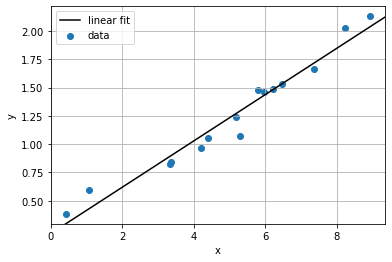

In [14]:
# plot the fit
plotdata()
plotline(w[0], w[1], label="linear fit")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

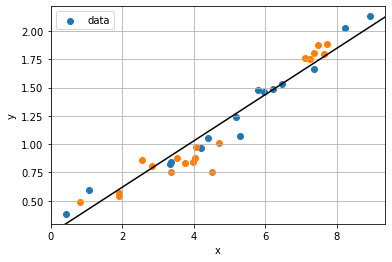

In [15]:
# plot fit on out of sample data
plotdata()
plotline(w[0], w[1])

xtest,ytest = sample_data(20)
plt.scatter(xtest,ytest,label="test")

# Approximating with a polynomial

In [16]:
# first, construct a Vandermonde matrix
n = 15
max_order = 10
X = np.zeros((n, max_order+1))

# method 1: use the default Vandermonde function from numpy
X = np.vander(x, max_order+1, increasing = True)
# method 2: use a for loop
# for k in range(max_order+1):
#     X[:,k] = x**(k)
    
# create a pandas dataframe with data = Vandermonde
col_list = ["order"+str(i) for i in range(max_order+1)]   
df1 = pd.DataFrame(data = X, columns=col_list)
df1

,order0,order1,order2,order3,order4,order5,order6,order7,order8,order9,order10
0,1.0,8.928602,79.719925,711.787443,6355.266442,56743.641581,506641.364154,4.523599e+06,4.038941e+07,3.606210e+08,3.219841e+09
1,1.0,3.319798,11.021059,36.587691,121.463744,403.235101,1338.659102,4.444078e+03,1.475344e+04,4.897845e+04,1.625985e+05
2,1.0,8.212291,67.441727,553.851105,4548.386575,37352.675185,306751.046862,2.519129e+06,2.068782e+07,1.698944e+08,1.395222e+09
3,1.0,0.416966,0.173861,0.072494,0.030228,0.012604,0.005255,2.191323e-03,9.137077e-04,3.809853e-04,1.588580e-04
4,1.0,1.076567,1.158996,1.247737,1.343272,1.446122,1.556847,1.676050e+00,1.804379e+00,1.942535e+00,2.091269e+00
5,1.0,5.950521,35.408696,210.700176,1253.775746,7460.618458,44394.564137,2.641708e+05,1.571954e+06,9.353942e+06,5.566083e+07
6,1.0,5.298174,28.070644,148.723144,787.961039,4174.754394,22118.573606,1.171880e+05,6.208826e+05,3.289544e+06,1.742857e+07
7,1.0,4.188074,17.539966,73.458682,307.650415,1288.462792,5396.177888,2.259959e+04,9.464878e+04,3.963961e+05,1.660136e+06
8,1.0,3.354078,11.249843,37.732855,126.558957,424.488676,1423.768339,4.775431e+03,1.601717e+04,5.372284e+04,1.801906e+05
9,1.0,6.225194,38.753044,241.245232,1501.798446,9348.987159,58199.261781,3.623017e+05,2.255399e+06,1.404029e+07,8.740356e+07


In [17]:
# helper function: create a Vandermonde matrix in pandas.dataframe
def Vandermonde_df(x, order = max_order):
    X = np.vander(x, order+1, increasing = True)
    col_list = ["order"+str(i) for i in range(order+1)]   
    df = pd.DataFrame(data = X, columns=col_list)
    return df

In [18]:
# solve least squares problem
model = sm.OLS(y, df1).fit()
w = model.params
print(w)

order0     121.634847
order1    -580.750926
order2     971.307923
order3    -804.409277
order4     387.304320
order5    -117.184775
order6      23.031717
order7      -2.942067
order8       0.235877
order9      -0.010787
order10      0.000215
dtype: float64


In [19]:
# output the prediction given our polynomial fit
# using X*w
df1.dot(w)

0     2.130451
1     0.847466
2     2.022922
3     0.383902
4     0.591226
5     1.472116
6     1.193113
7     0.980092
8     0.811906
9     1.526781
10    1.037409
11    1.667587
12    1.154493
13    1.410077
14    1.517587
dtype: float64

In [20]:
# output the prediction given our polynomial fit
# using statsmodels predict function
model.predict(df1)

0     2.130451
1     0.847466
2     2.022922
3     0.383902
4     0.591226
5     1.472116
6     1.193113
7     0.980092
8     0.811906
9     1.526781
10    1.037409
11    1.667587
12    1.154493
13    1.410077
14    1.517587
dtype: float64

In [21]:
#computes our polynomial fit evaluated at x
def p(x, order = max_order, w = w):
    df = Vandermonde_df(x, order)
    y = df.dot(w)
    return np.array(y)

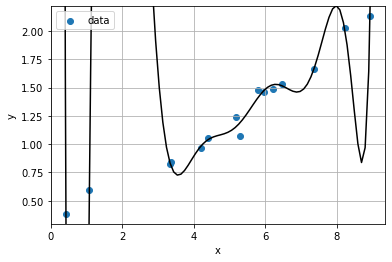

In [22]:
# plot fit
plotdata()
plotfunc(p, xmin=0, xmax=10)

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

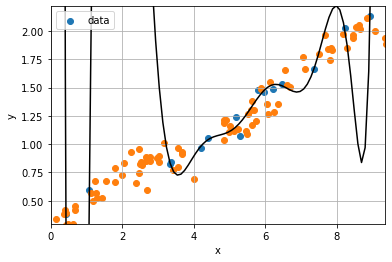

In [23]:
# plot fit on out of sample data
plotdata()
plotfunc(p, xmin=0, xmax=10)

xtest,ytest = sample_data(100)
plt.scatter(xtest,ytest,label="test")

# Choosing the best model order

In [24]:
max_model_order = 10
rmse = np.zeros(max_model_order+1)       # array to store root mean square model errors
rmse_train = np.zeros(max_model_order+1) # array to store root mean square model errors on training set
xtest,ytest = sample_data(50)   # generate test set

for model_order in range(max_model_order+1):
    # form Vandermonde matrix
    df = Vandermonde_df(x, model_order)
    
    # solve least squares problem
    model = sm.OLS(y, df).fit()
    w = model.params
    ytrain = df.dot(w)
    
    # compute training error 
    rmse_train[model_order] = np.mean(np.abs(y - np.array(ytrain))) # sqrt(mean((y - X*w).^2))
    
    # compute test error
    ptest = p(xtest, order=model_order, w=w)
    rmse[model_order] = np.mean(np.abs(ytest - np.array(ptest))) # sqrt(mean((ytest - ptest).^2))
rmse

array([ 0.53558514,  0.09219372,  0.11267527,  0.10313493,  0.07633348,
        0.11427176,  0.09231839,  0.22500731,  0.96274495,  1.11348529,
       16.46716875])

Text(0, 0.5, 'rmse')

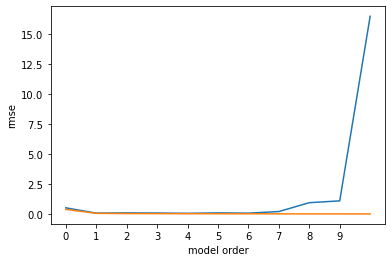

In [25]:
plt.plot(range(max_model_order+1),rmse, label="test error")
plt.plot(range(max_model_order+1),rmse_train, label="train error")
plt.xticks(np.arange(0,10,step=1.0))
plt.xlabel("model order")
plt.ylabel("rmse")

# Polynomial models for classification

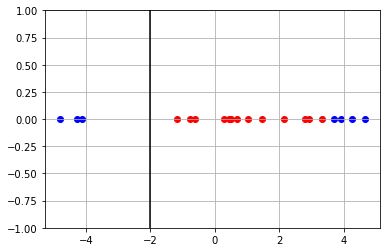

In [27]:
np.random.seed(0)
n = 20
xs = 10*(rand(n) - .5)
ys = (xs)**2
pos = (xs - 1)**2 >= 7
zn=np.zeros(n)
pt = plt.scatter(xs[pos],zn[pos],color="blue", label="positive")
plt.scatter(xs[~pos],zn[~pos],color="red", label="negative")
plt.plot([-2,-2], [-1,1], color="black", label="classification boundary")#, ticks=:none, border=:none, legend=false)
plt.ylim([-1,1])
plt.grid()
# savefig("poly-class-1d.pdf")
pt

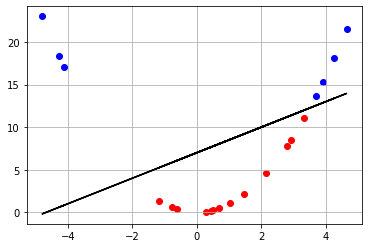

In [28]:
pt = plt.scatter(xs[pos],ys[pos],color="blue", label="positive")
plt.scatter(xs[~pos],ys[~pos],color="red", label="negative")
plt.plot(xs, 1.5*xs + 7, color="black", label="classification boundary")
plt.grid()
# savefig("poly-class-2d.pdf")
pt

In [29]:
# Example 1: multivariate polynomial classification 
n = 1000
scale = 50
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -30 - 9*x1 + 2*x2 + x1**2 - 0*x1*x2 + x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

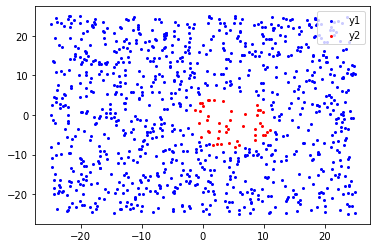

In [30]:
plt.scatter(x1[pos], x2[pos], color="blue", s=4, label='y1')
plt.scatter(x1[neg], x2[neg], color="red", s=4, label='y2')
plt.legend(loc="upper right")

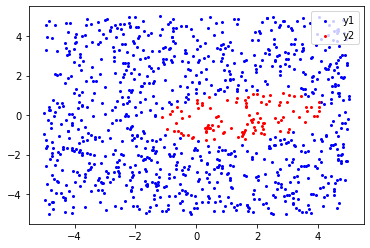

In [31]:
# Example 2: multivariate polynomial classification 
n = 1000
scale = 10
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 + 5*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], s=4, color="blue", label="y1")
plt.scatter(x1[neg], x2[neg], s=4, color="red", label="y2")
plt.legend(loc="upper right")

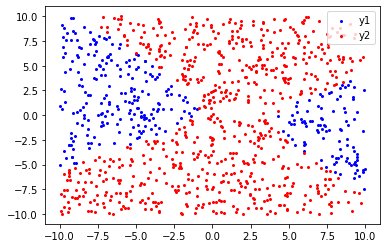

In [32]:
# Example 3: multivariate polynomial classification 
n = 1000
scale = 20
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 - 2*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], color="blue", s=4, label="y1")
plt.scatter(x1[neg], x2[neg], color="red", s=4, label="y2")
plt.legend(loc="upper right")